# <font color=#4863A0>Model Training</font>

## <font color=#4863A0>1. Import Data and Requiered Packages</font>

In [1]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

*<font color=#4863A0>Read CSV Data and Show the top 10 records</font>*

In [3]:
df = pd.read_csv("./data/DATA_CLEANED.csv")
df.head(10)

,engine_size,cylinders,transmission,fuel_type,fuel_consumption_city,fuel_consumption_hwy,fuel_consumption_comb,fuel_consumption_comb_mpg,co2_emissions,make_type,vehicle_class_type
0,2.0,4,AS5,Z,9.9,6.7,8.5,33,196.0,Luxury,Hatchback
1,2.4,4,M6,Z,11.2,7.7,9.6,29,221.0,Luxury,Hatchback
2,1.5,4,AV7,Z,6.0,5.8,5.9,47,136.0,Luxury,Hatchback
3,3.5,6,AS6,Z,12.7,9.1,11.1,25,255.0,Luxury,SUV
4,3.5,6,AS6,Z,12.1,8.7,10.6,27,244.0,Luxury,SUV
5,3.5,6,AS6,Z,11.9,7.7,10.0,28,230.0,Luxury,Sedan
6,3.5,6,AS6,Z,11.8,8.1,10.1,28,232.0,Luxury,Sedan
7,3.7,6,AS6,Z,12.8,9.0,11.1,25,255.0,Luxury,Sedan
8,3.7,6,M6,Z,13.4,9.5,11.6,24,267.0,Luxury,Sedan
9,2.4,4,AS5,Z,10.6,7.5,9.2,31,212.0,Luxury,Hatchback


In [4]:
df.shape

(6282, 11)

## <font color=#4863A0>2. Preparing X and Y variables</font>

In [18]:
X = df.drop(columns=["co2_emissions"], axis=1)
y = df["co2_emissions"]

In [19]:
category_columns = df.select_dtypes(include=[object]).columns
for col in category_columns:
    print(f"Categories in '{col}':")
    print(df[f'{col}'].unique(),'\n')

Categories in 'transmission':
['AS5' 'M6' 'AV7' 'AS6' 'AM6' 'A6' 'AM7' 'AV8' 'AS8' 'A7' 'A8' 'M7' 'A4'
 'M5' 'AV' 'A5' 'AS7' 'A9' 'AS9' 'AV6' 'AS4' 'AM5' 'AM8' 'AM9' 'AS10'
 'A10' 'AV10'] 

Categories in 'fuel_type':
['Z' 'D' 'X' 'E' 'N'] 

Categories in 'make_type':
['Luxury' 'Premium' 'Sports' 'General'] 

Categories in 'vehicle_class_type':
['Hatchback' 'SUV' 'Sedan' 'Truck'] 



### <font color=#4863A0>2.1. Create Column Transformer with 3 types of transformers</font>

In [20]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Obtener los nombres de las columnas numéricas y categóricas de X
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

# Crear objetos para transformar los datos
oh_transformer = OneHotEncoder()
numeric_transformer = StandardScaler()

# Crear un objeto ColumnTransformer que aplica el OneHotEncoder a las columnas categóricas y el StandardScaler a las columnas numéricas
preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)

In [21]:
# transform 
X = preprocessor.fit_transform(X)
X.shape

(6282, 46)

## <font color=#4863A0>3. Separate dataset into train and test</font>

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((5025, 46), (1257, 46))

## <font color=#4863A0>4. Modeling</font>

### <font color=#4863A0>4.1. Create and Evaluate Function to Give All Metrics After Model Training</font>

In [26]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square, mse

### <font color=#4863A0>4.2. Create, Train and Evaluate Models</font>

In [27]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(ccp_alpha=0.007),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=300),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2, model_train_mse = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2, model_test_mse = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- mse: {:.4f}".format(model_train_mse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- mse: {:.4f}".format(model_test_mse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 5.3341
- mse: 28.4522
- Mean Absolute Error: 2.8785
- R2 Score: 0.9916
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.7374
- mse: 32.9176
- Mean Absolute Error: 3.1410
- R2 Score: 0.9904


Lasso
Model performance for Training set
- Root Mean Squared Error: 9.6459
- mse: 93.0431
- Mean Absolute Error: 5.9842
- R2 Score: 0.9725
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 10.3694
- mse: 107.5241
- Mean Absolute Error: 6.4087
- R2 Score: 0.9687


Ridge
Model performance for Training set
- Root Mean Squared Error: 5.3398
- mse: 28.5137
- Mean Absolute Error: 2.8965
- R2 Score: 0.9916
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.7213
- mse: 32.7327
- Mean Absolute Error: 3.1355
- R2 Score: 0.9905


K-Neighbors Regressor
Model performance for Training set
- Root Mean Sq

### <font color=#4863A0>4.3. Results</font>

In [28]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
6,XGBRegressor,0.996054
5,Random Forest Regressor,0.996049
4,Decision Tree,0.995845
7,CatBoosting Regressor,0.995476
2,Ridge,0.990473
0,Linear Regression,0.990419
3,K-Neighbors Regressor,0.985350
1,Lasso,0.968703
8,AdaBoost Regressor,0.944425


* The best model is XGBRegressor

### <font color=#4863A0>5. XGBRegressor</font>

In [29]:
XGB_model = XGBRegressor(fit_intercept=True)
XGB_model = XGB_model.fit(X_train, y_train)
y_pred = XGB_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

[19:11:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "fit_intercept" } are not used.

 Accuracy of the model is 99.61


* The model predict values close to real value

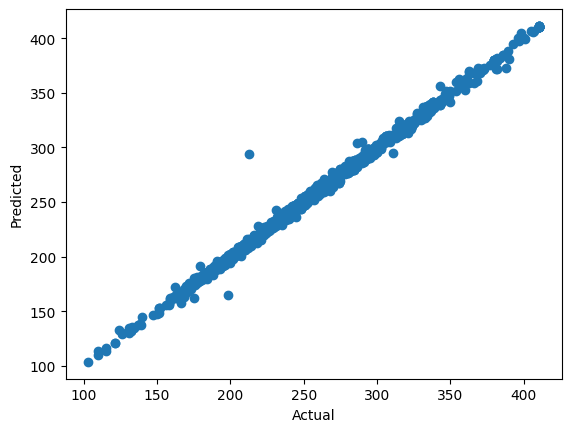

In [30]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

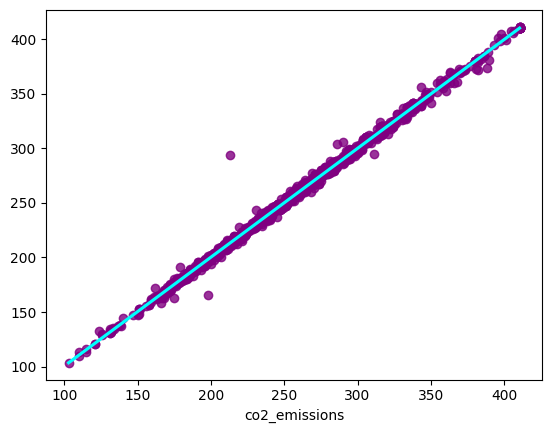

In [37]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='cyan', scatter_kws={"color": "purple"});

### <font color=#4863A0>6. Difference Between Actual and Predicted Values</font>

In [38]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
2794,322.0,324.018616,-2.018616
5260,242.0,243.457901,-1.457901
2187,300.0,296.133240,3.866760
5303,275.0,272.995819,2.004181
3195,245.0,244.777267,0.222733
...,...,...,...
5507,197.0,197.040787,-0.040787
2364,220.0,217.508453,2.491547
2952,303.0,298.718231,4.281769
2252,195.0,191.719910,3.280090
